In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
np.random.seed(1)
tf.random.set_seed(2)
# basic paths
train_dir = "./dataset_v7/train"
test_dir = "./dataset_v7/test"
val_dir = "./dataset_v7/validation"

class_names = os.listdir(train_dir)
num_classes = len(class_names)

def get_dir_filenames(base_dir, name):
    dir = os.path.join(base_dir, name)

    return {"dir": dir, "file_names": os.listdir(dir)}


train = {name: get_dir_filenames(train_dir, name) for name in class_names}
val = {name: get_dir_filenames(val_dir, name) for name in class_names}

In [3]:
train_len = sum(map(lambda x: len(x['file_names']), train.values()))
val_len = sum(map(lambda x: len(x['file_names']), val.values()))

print(f"Total training images: {train_len}")
print(f"Total validation images: {val_len}")

Total training images: 80
Total validation images: 14


In [4]:
img_input = layers.Input(shape=(150, 150, 3))

x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)

x = layers.Dropout(0.2)(x)

x = layers.Dense(128, activation='relu')(x)

output = layers.Dense(num_classes, activation='softmax')(x)

model = Model(img_input, output)

model.summary()

model.compile(loss='categorical_crossentropy',
            optimizer=RMSprop(learning_rate=0.001),
            metrics=['acc'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496 

2022-06-08 15:28:17.748572: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-08 15:28:17.748637: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arch): /proc/driver/nvidia/version does not exist
2022-06-08 15:28:17.750111: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2,391,845
Trainable params: 2,391,845
Non-trainable params: 0
_________________________________________________________________


In [5]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    zoom_range=0.4,
    horizontal_flip=True,
)
# train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=6,
        class_mode='categorical',
        subset='training')


validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=2,
        class_mode='categorical')

Found 80 images belonging to 5 classes.
Found 14 images belonging to 5 classes.


In [6]:
history = model.fit(
      train_generator,
      epochs=20,
      validation_data=validation_generator,)

Epoch 1/20
14/14 [==============================] - 7s 383ms/step - loss: 1.8044 - acc: 0.1750 - val_loss: 1.5971 - val_acc: 0.2857
Epoch 2/20
14/14 [==============================] - 5s 376ms/step - loss: 1.5628 - acc: 0.3375 - val_loss: 1.4468 - val_acc: 0.3571
Epoch 3/20
14/14 [==============================] - 7s 495ms/step - loss: 1.4803 - acc: 0.3625 - val_loss: 2.0889 - val_acc: 0.2143
Epoch 4/20
14/14 [==============================] - 5s 373ms/step - loss: 1.5319 - acc: 0.2625 - val_loss: 1.4779 - val_acc: 0.4286
Epoch 5/20
14/14 [==============================] - 5s 383ms/step - loss: 1.3485 - acc: 0.3750 - val_loss: 1.2554 - val_acc: 0.5714
Epoch 6/20
14/14 [==============================] - 6s 433ms/step - loss: 1.3123 - acc: 0.4250 - val_loss: 1.5144 - val_acc: 0.1429
Epoch 7/20
14/14 [==============================] - 6s 458ms/step - loss: 1.2361 - acc: 0.5250 - val_loss: 1.1510 - val_acc: 0.5714
Epoch 8/20
14/14 [==============================] - 5s 355ms/step - loss: 1.

Text(0.5, 1.0, 'Training and validation loss')

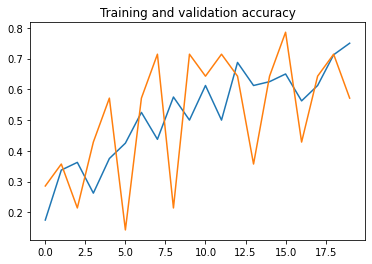

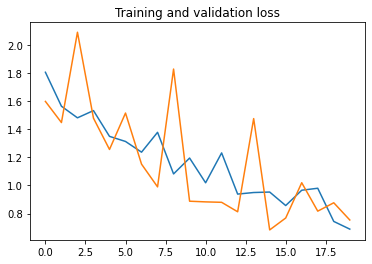

In [7]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [8]:
tf.keras.models.save_model(model, 'sta_cnn.h5')

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

logits = model.predict(test_generator,steps=nb_samples)
prediction = tf.nn.softmax(logits)
print(prediction)

Found 13 images belonging to 5 classes.
tf.Tensor(
[[0.15302518 0.16050021 0.15194331 0.1515488  0.38298255]
 [0.15135807 0.38921034 0.1513123  0.15108402 0.15703516]
 [0.1819236  0.19866697 0.22113653 0.16540065 0.23287225]
 [0.1550044  0.1585125  0.15528367 0.36080515 0.17039429]
 [0.15760967 0.16292778 0.15396062 0.16351968 0.36198226]
 [0.21643978 0.16290121 0.16247965 0.24652162 0.21165778]
 [0.17108274 0.17488496 0.30887    0.16032225 0.18484008]
 [0.14888105 0.14892349 0.14887583 0.14889632 0.4044233 ]
 [0.15603548 0.16307165 0.16936637 0.3471566  0.16436982]
 [0.15757833 0.15777226 0.15730062 0.31550574 0.21184301]
 [0.1824975  0.1592437  0.16382232 0.33515224 0.1592842 ]
 [0.16075222 0.36743128 0.15974005 0.15400544 0.15807112]
 [0.24460863 0.23391949 0.1844684  0.1617318  0.17527169]], shape=(13, 5), dtype=float32)
